# Project Machine Learning for cybersecurity : Anti Malware System - A Deep Learning Approach using Support Vector Machine (SVM) for Malware Classification


In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [61]:
# Charger le fichier NPZ
data = np.load('images_malware.npz', allow_pickle=True)

# Afficher les clés disponibles dans le fichier NPZ
print("Clés disponibles dans le fichier NPZ :", list(data.keys()))

# Afficher les valeurs associées à chaque clé
for key in data.keys():
    print(f"Clé : {key}")
    print(data[key])  # Afficher la valeur associée à la clé

Clés disponibles dans le fichier NPZ : ['arr']
Clé : arr
[[array([[  0,   0,   0, ...,   0,   0,   0],
         [ 24,   0,  69, ...,   0, 144, 255],
         [232, 242, 251, ..., 235, 139,   0],
         ...,
         [ 88, 124, 124, ...,  95,  92,  56],
         [ 27, 243, 250, ..., 250, 243, 243],
         [115,  48, 129, ..., 199,  23, 252]], dtype=uint8) 0]
 [array([[  0,   0,   0, ...,   0,   0,   0],
         [ 24,   0,  69, ...,   0, 144, 255],
         [139, 139, 209, ..., 139,   2, 196],
         ...,
         [ 35,  44,  40, ...,  88, 124,  37],
         [233, 248, 134, ...,  27,  32, 247],
         [134,  19, 252, ..., 137, 176,  43]], dtype=uint8) 0]
 [array([[  0,   0,   0, ...,   0,   0,   0],
         [ 24,   0,  69, ...,   0, 144, 255],
         [232, 242, 251, ..., 235, 139,   0],
         ...,
         [ 88, 124, 124, ...,  95,  92,  56],
         [ 27, 243, 250, ..., 250, 243, 243],
         [115,  48, 129, ..., 199,  23, 252]], dtype=uint8) 0]
 ...
 [array([[  0,  8

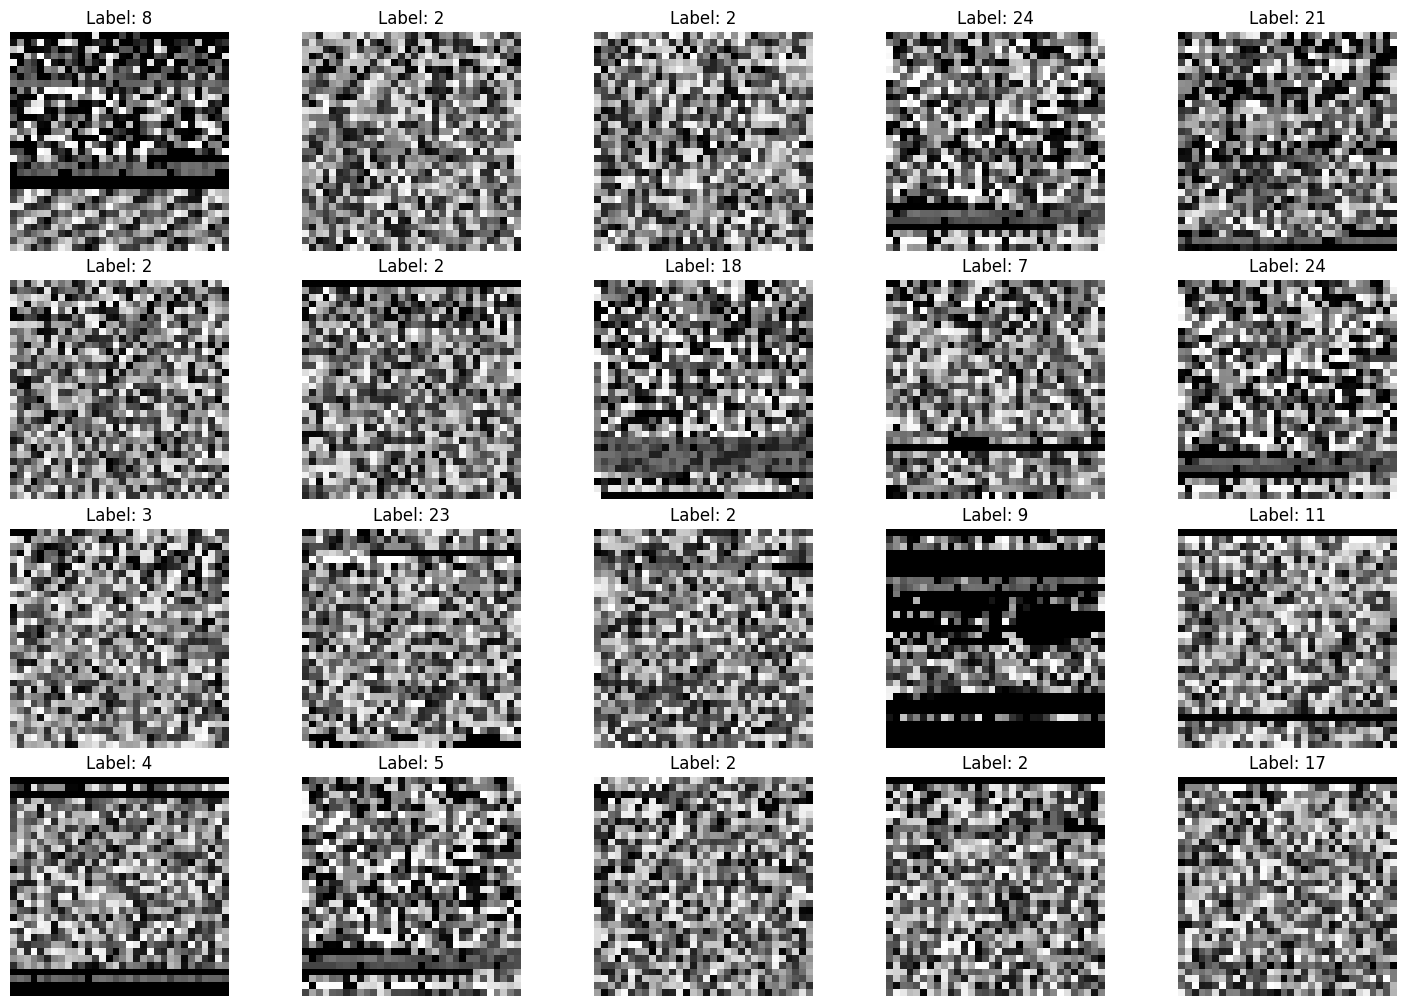

In [62]:
# Récupérer les données
images = data['arr'][:, 0]  # Supposons que les images sont dans la première colonne
labels = data['arr'][:, 1]  # Supposons que les étiquettes sont dans la deuxième colonne

# Nombre total d'images dans le dataset
total_images = len(images)

# Sélectionner 20 indices au hasard
random_indices = np.random.choice(total_images, size=20, replace=False)

# Afficher les images sélectionnées aléatoirement avec leurs étiquettes
num_images_per_row = 5
num_rows = (len(random_indices) - 1) // num_images_per_row + 1

plt.figure(figsize=(15, 10))  # Taille de la figure

for i, idx in enumerate(random_indices):
    plt.subplot(num_rows, num_images_per_row, i + 1)
    plt.imshow(images[idx], cmap='gray')  # Affichage en nuances de gris
    plt.title(f'Label: {labels[idx]}')
    plt.axis('off')  # Désactiver les axes

plt.tight_layout(pad=0.5)  # Ajuster la disposition pour un espacement optimal
plt.show()

In [72]:
# Charger les données
data = np.load('images_malware.npz', allow_pickle=True)
images_labels = data['arr']

# Séparer les images et les étiquettes
images = []
labels = []
for img, label in images_labels:
    images.append(img)
    labels.append(label)

# Convertir en tableaux NumPy
images = np.array(images)
labels = np.array(labels)

# Diviser les données en ensembles d'entraînement et de test (80% pour l'entraînement, 20% pour le test)
images, test_images, labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)


# Conversion des images en tenseurs PyTorch
images_tensor = torch.from_numpy(images).float()
labels_tensor = torch.from_numpy(labels).long()
test_images_tensor = torch.from_numpy(images).float()
test_labels_tensor = torch.from_numpy(labels).long()

print("Data Type Image Tensor :", images_tensor.dtype)
print("Data Type Label Tensor :", labels_tensor.dtype)
print("Data Shape Image Tensor :", images_tensor.shape)
print("Data Shape Label Tensor :", labels_tensor.shape)


Data Type Image Tensor : torch.float32
Data Type Label Tensor : torch.int64
Data Shape Image Tensor : torch.Size([7471, 32, 32])
Data Shape Label Tensor : torch.Size([7471])


In [66]:
# Définir le modèle CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 36, kernel_size=5, stride=1, padding=2)
        self.leaky_relu1 = nn.LeakyReLU(0.01)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(36, 72, kernel_size=5, stride=1, padding=2)
        self.leaky_relu2 = nn.LeakyReLU(0.01)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(72 * 8 * 8, 1024)
        self.leaky_relu3 = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(p=0.85)
        self.fc2 = nn.Linear(1024, 25)

    def forward(self, x):
        x = self.pool1(self.leaky_relu1(self.conv1(x)))
        x = self.pool2(self.leaky_relu2(self.conv2(x)))
        x = x.view(-1, 72 * 8 * 8)  # Ajustement de la taille avant la couche FC
        x = self.dropout(self.leaky_relu3(self.fc1(x)))
        x = self.fc2(x)
        return x


# Créer un TensorDataset
dataset = TensorDataset(images_tensor, labels_tensor)

# DataLoader
batch_size = 256
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = CNN()

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)


In [67]:
# Entraîner le modèle
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(data_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))  # Ajouter la dimension du canal
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(data_loader)}')

Epoch [1/5], Loss: 4.661931045850118
Epoch [2/5], Loss: 2.2039743383725483
Epoch [3/5], Loss: 1.9203725496927897
Epoch [4/5], Loss: 1.705043085416158
Epoch [5/5], Loss: 1.5600032567977906


In [59]:
from sklearn.svm import SVC

# Récupérer les embeddings des images après la première couche FC
def get_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    targets = []
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data
            outputs = model(inputs.unsqueeze(1))
            # Aplatir les embeddings pour les rendre compatibles avec le SVM
            embeddings.extend(outputs.view(outputs.size(0), -1).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return embeddings, targets

# Obtenir les embeddings
embeddings, targets = get_embeddings(model, data_loader)

# Entraîner le SVM
svm = SVC(C=10, kernel='linear')
svm.fit(embeddings, targets)

SVC(C=10, kernel='linear')

In [73]:
# Créer un TensorDataset pour les données de test
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# DataLoader pour les données de test
test_batch_size = 256
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# Obtenir les embeddings des données de test
test_embeddings, test_targets = get_embeddings(model, test_loader)

# Faire des prédictions sur les données de test avec le SVM
svm_predictions = svm.predict(test_embeddings)

# Calculer la précision
accuracy = accuracy_score(test_targets, svm_predictions)
print(f"Précision du SVM sur les données de test : {accuracy}")

# Afficher le rapport de classification
print("Rapport de classification :")
print(classification_report(test_targets, svm_predictions))

Précision du SVM sur les données de test : 0.5839914335430331
Rapport de classification :
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        86
           1       1.00      0.38      0.55        97
           2       0.71      0.72      0.72      2357
           3       0.61      0.61      0.61      1281
           4       0.36      0.91      0.52       153
           5       0.12      1.00      0.22        88
           6       0.10      0.16      0.12       166
           7       0.11      0.12      0.11       119
           8       0.56      0.91      0.70       128
           9       1.00      1.00      1.00       128
          10       0.98      0.57      0.72       312
          11       0.87      0.99      0.93       342
          12       0.66      0.15      0.25       176
          13       0.72      0.71      0.71       143
          14       1.00      0.98      0.99       100
          15       0.18      0.17      0.18  

c:\Users\yanis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yanis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yanis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,